Created: 6 Sep 2018

Author: Ben Branchflower

This file gets information on soldiers that enlisted in Georgia and died serving in World War one and looks at the information we get about detah place and date.


In [1]:
from bs4 import BeautifulSoup
import pandas as pd
from matplotlib import pyplot as plt
import requests
import seaborn

Getting the raw source code of the page with the data on the soldiers

In [2]:
with requests.Session() as s:
    # letting them know who I am and assuring I get the same response type every time
    s.headers.update({'User-Agent':'benbranchflower@gmail.com', 'Accept':'tex/html'})
    response = s.get('https://www.worldwar1centennial.org/index.php/georgia-memorial-database.html')
    if response.status_code != 200:
        raise ValueError("Bad response code")

There is only one table in the response text so I can just loop over the rows and get data on each of the individuals 

In [3]:
soup = BeautifulSoup(response.text, 'html5lib')
# this next line makes the table a list of list to be fed into the pandas Dataframe instantiation
df = pd.DataFrame([[d.text for d in row.find_all('td')][:-1] for row in soup.find_all('tr')])
# Moving the first row to be the headers and the dropping them
df.columns = df.iloc[0,:]
df = df.reindex(df.index.drop(0)) 
# taking a peek to see if things are working properly
df.head()

,Rank,Name,County,City,Death date,Eth.,Citation,Disposition,Photo
1,PVT,"Aaron, Charlie Floyd",Newton,Starrsville,9-Oct-1918,W,"MB 132, Newton, GDC, Knight",infection - France,yes
2,CPL,"Abercrombie, Lewis Felton",Fulton,Atlanta,8-Jun-1918,W,GDC,wound,
3,PVT,"Abner, Cecil",Polk,Rockmart,23-May-1919,W,"MB 136, GDC, Knight",pneumonia - overseas,yes
4,PVT,"Abner, Lewis Felton",Polk,,23-Aug-1918,,GDC,pneumonia,
5,PVT,"Adair, Chester Price",Clarke,Athens,14-Sep-1918,W,"MB 051, Knight",infection,yes


The data is pretty messy so I will clean up some column names and then make some new columns from what we have so the columns are a little more precise.

In [4]:
df.rename({'Eth.':'Ethnicity'}, axis='columns', inplace=True)
df['Death Place'] = df.Disposition.str.extract(r'-\s([A-Z].+)\s?$')
df['State'] = 'Georgia'
df['Surname'] = df.Name.str.extract(r'^(.+),')
df['Given Names'] = df.Name.str.extract(r', (.+)$')
df['Death Day'] = df['Death date'].str.extract(r'^(\d{1,2})-')
df['Death Month'] = df['Death date'].str.extract(r'-(\w+)-')
df['Death Year'] = df['Death date'].str.extract(r'-(\d{4})$')
df['Death Month Year'] = df['Death Month'].str.cat(df['Death Year'], sep=' ')
df['Death date'] = df['Death date'].str.replace(r'-', ' ')
df.head() # looking at the next version of the data

,Rank,Name,County,City,Death date,Ethnicity,Citation,Disposition,Photo,Death Place,State,Surname,Given Names,Death Day,Death Month,Death Year,Death Month Year
1,PVT,"Aaron, Charlie Floyd",Newton,Starrsville,9 Oct 1918,W,"MB 132, Newton, GDC, Knight",infection - France,yes,France,Georgia,Aaron,Charlie Floyd,9,Oct,1918,Oct 1918
2,CPL,"Abercrombie, Lewis Felton",Fulton,Atlanta,8 Jun 1918,W,GDC,wound,,NaN,Georgia,Abercrombie,Lewis Felton,8,Jun,1918,Jun 1918
3,PVT,"Abner, Cecil",Polk,Rockmart,23 May 1919,W,"MB 136, GDC, Knight",pneumonia - overseas,yes,NaN,Georgia,Abner,Cecil,23,May,1919,May 1919
4,PVT,"Abner, Lewis Felton",Polk,,23 Aug 1918,,GDC,pneumonia,,NaN,Georgia,Abner,Lewis Felton,23,Aug,1918,Aug 1918
5,PVT,"Adair, Chester Price",Clarke,Athens,14 Sep 1918,W,"MB 051, Knight",infection,yes,NaN,Georgia,Adair,Chester Price,14,Sep,1918,Sep 1918


Now that what we have is a little cleaner, let's move on to getting some counts of the occurences of different counties, death place, surnames and death month.

In [5]:
surn_occurs = dict(df['Surname'].value_counts()) # getting a dictionary for numbers of appearances
df['surn_occur'] = [surn_occurs.get(x, 0) for x in df['Surname']] # filling the column with the corresponding data
dp_occurs = dict(df['Death Place'].value_counts()) # lather
df['dplace_occur'] = [dp_occurs.get(x, 0) for x in df['Death Place']]
dm_occurs = dict(df['Death Month Year'].value_counts()) # rinse
df['dmonth_occur'] = [dm_occurs.get(x, 0) for x in df['Death Month Year']]
dp_co_occurs = df['Death Place'].str.cat(df['County']).value_counts(dropna=True) # repeat
df['county_dplace_occur'] = [dp_co_occurs.get(x, 0) for x in df['Death Place'].str.cat(df['County']).fillna('')]
df.head()

,Rank,Name,County,City,Death date,Ethnicity,Citation,Disposition,Photo,Death Place,...,Surname,Given Names,Death Day,Death Month,Death Year,Death Month Year,surn_occur,dplace_occur,dmonth_occur,county_dplace_occur
1,PVT,"Aaron, Charlie Floyd",Newton,Starrsville,9 Oct 1918,W,"MB 132, Newton, GDC, Knight",infection - France,yes,France,...,Aaron,Charlie Floyd,9,Oct,1918,Oct 1918,1,187,1136,4
2,CPL,"Abercrombie, Lewis Felton",Fulton,Atlanta,8 Jun 1918,W,GDC,wound,,NaN,...,Abercrombie,Lewis Felton,8,Jun,1918,Jun 1918,1,0,93,0
3,PVT,"Abner, Cecil",Polk,Rockmart,23 May 1919,W,"MB 136, GDC, Knight",pneumonia - overseas,yes,NaN,...,Abner,Cecil,23,May,1919,May 1919,2,0,21,0
4,PVT,"Abner, Lewis Felton",Polk,,23 Aug 1918,,GDC,pneumonia,,NaN,...,Abner,Lewis Felton,23,Aug,1918,Aug 1918,2,0,105,0
5,PVT,"Adair, Chester Price",Clarke,Athens,14 Sep 1918,W,"MB 051, Knight",infection,yes,NaN,...,Adair,Chester Price,14,Sep,1918,Sep 1918,2,0,297,0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 <a list of 38 Text xticklabel objects>)

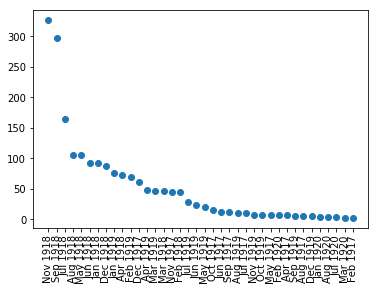

In [6]:
plot_info = {x:y for x, y in dm_occurs.items() if y > 2 and y < 500}
plt.scatter(plot_info.keys(), plot_info.values())
plt.xticks(rotation='vertical')

So it looks like the biggest times of death were September and November of 1918. Let's look at how that looks if we separate the data by location as well. We should be able to get a feel for where some of the battles were if a lot casualties occured in one place at a given time.

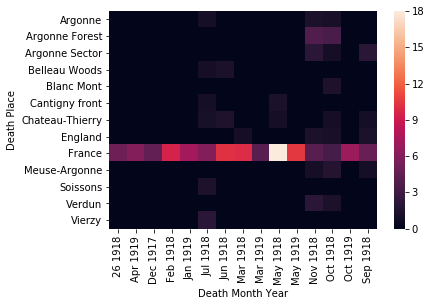

In [7]:
# creating a summay table of deaths by month and death place
dp_by_dm = pd.pivot_table(df, index='Death Month Year', columns='Death Place', values='county_dplace_occur', dropna=True, fill_value=0)
dp_by_dm.dropna(how='all', inplace=True)
dp_by_dm = dp_by_dm[dp_by_dm.max(axis=1) > 3]
dp_by_dm = dp_by_dm.transpose()[dp_by_dm.transpose().max(axis=1) > 1]
seaborn.heatmap(dp_by_dm)

Let's do a similar thing with places the soldiers enlisted and where the soldiers died to look at how the deaths change by places and month of death.

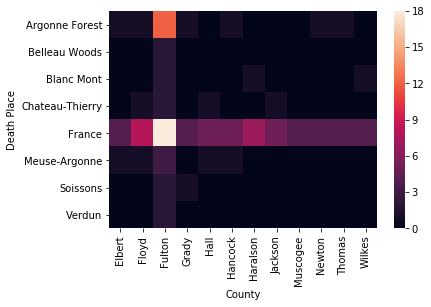

In [8]:
dp_by_co = pd.pivot_table(df, index='County', columns='Death Place', values='county_dplace_occur', dropna=True, fill_value=0)
dp_by_co.dropna(how='all', inplace=True)
dp_by_co = dp_by_co[dp_by_co.max(axis=1) > 3]
dp_by_co = dp_by_co.transpose()[dp_by_co.transpose().max(axis=1) > 1]
seaborn.heatmap(dp_by_co)

The data doesn't differentiate very well to the areas of France so we couldn't get a whole lot of information but we were able to learn a few things.